In [ ]:
!pip install -q -U keras-tuner
!pip install git+https://github.com/qubvel/classification_models.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-f_6tejuu
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-f_6tejuu
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.2 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=c9b692573cc2c7046885d3dd9206e70395ad6433b137f4bddff62c2409da23ef
  Stored in directory: /tmp/pip-ephem-wheel-c

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/2022 산학연계/COMPARISON_SYSTEM')

Mounted at /content/drive


In [ ]:
# Import Module
from vgg16_module import *
from resnext_module import *
from resnet50_module import *
from densenet_module import *

Found GPU at: /device:GPU:0


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
pd.options.display.max_columns = None 
pd.options.display.max_rows = None

# **CLASS: Comparison System**

In [ ]:
class ComparisonSystem:
  # 데이터 및 초기값
  def __init__(self, X, y, num_class=10, epochs=16, rows=32, cols=32):
    self.X = X
    self.y = y

    self.NUM_CLASS = num_class
    self.EPOCHS = epochs

    self.BATCH_SIZE = 64
    self.RANDOM_SEED = 1023

    self.ROWS = rows
    self.COLS = cols
    self.IMG_DIM = (self.ROWS, self.COLS, 3)


  # Data split: Train:Valid:Test = 6:2:2
  def dataSplit(self):
    self.X = self.X.astype(float)/255

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=int(len(self.X)*0.4), random_state=self.RANDOM_SEED)
    self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(self.X_test, self.y_test, test_size=0.5)

  
  # Module Class Setting
  def setSystem(self):
    self.moduleList = []

    self.moduleList.append(ModuleVGG16(self.X, self.y, self.NUM_CLASS, self.IMG_DIM, self.BATCH_SIZE, self.EPOCHS, self.RANDOM_SEED))
    self.moduleList.append(myResNext(self.X, self.y, self.NUM_CLASS, self.BATCH_SIZE, self.EPOCHS, self.RANDOM_SEED))
    self.moduleList.append(modelResnet50(self.X, self.y, self.NUM_CLASS, self.IMG_DIM, self.BATCH_SIZE, self.EPOCHS, self.RANDOM_SEED))
    self.moduleList.append(modelDensenet(self.X, self.y, self.NUM_CLASS, self.IMG_DIM, self.BATCH_SIZE, self.EPOCHS, self.RANDOM_SEED))


  # Running Module: VGG16 - ResNext - ResNet50 - DenseNet
  def runSystem(self):
    self.result = []

    for md in self.moduleList:
      md.preprocessing()
      md.inference()
      mdResult = md.predictResult()

      # Add Running result - ALL MODULE
      self.result.extend(mdResult)

    return self.result


  # Sorting Method
  def sortF1(self, e):
    return -e['f1']

  def sortACC(self, e):
    return -e['accuracy']

  def sortIT(self, e):
    return e['inference_time']


  # Sorting Result: F1, Accuracy, Inference Time
  def sortResult(self):
    self.resultF1 = sorted(self.result, key=self.sortF1)
    self.resultACC = sorted(self.result, key=self.sortACC)
    self.resultIT = sorted(self.result, key=self.sortIT)
    

  # Getting Best Result
  def getResult(self, standard='all', num=0):
    if standard == 'all': # default: print F1, ACC, IT
      self.bestResult = []
      self.bestResult.append(self.resultF1[num])
      self.bestResult.append(self.resultACC[num])
      self.bestResult.append(self.resultIT[num])

      bestdf = pd.DataFrame (self.bestResult)
      return bestdf

    elif standard == 'f1': # print F1 model
      return self.resultF1[num]

    elif standard == 'accuracy': # print ACC model
      return self.resultACC[num]

    elif standard == 'inference time': # print IF model
      return self.resultIT[num]


  # Get Model what you want
  def getModule(self, module, num=0):
    if module == 'vgg16':
      return self.modueList[0].getModel(num)
    elif module == 'resnext':
      return self.modueList[1].getModel(num)
    elif module == 'resnet':
      return self.modueList[2].getModel(num)
    elif module == 'densenet':
      return self.modueList[3].getModel(num)

# **CLASS: Image Reszing**
- https://koos808.tistory.com/42

In [ ]:
from PIL import Image
import os

class ResizeImage:
  def __init__(self, raw_path, data_path, rows, cols):
    self.raw_path = raw_path # 원본 이미지 경로
    self.data_path = data_path # 저장할 이미지 경로

    # 원본 이미지 경로 내 폴더들 list
    self.token_list = os.listdir(raw_path)

    self.ROWS = rows
    self.COLS = cols

  def resizing(self):
    for token in self.token_list:
      image_path = self.raw_path + token + '/'
      save_path = self.data_path + token + '/'

    # 저장할 경로 없으면 생성
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    #원본 이미지 경로의 모든 이미지 list 지정
    data_list = os.listdir(image_path)
    print(len(data_list))

    # 모든 이미지 resize 후 저장하기
    for name in data_list:
        im = Image.open(image_path + name)

        im = im.resize((self.ROWS, self.COLS))

        im = im.convert('RGB')
        im.save(save_path + name)
    print('end ::: ' + token)

# **CLASS: Visualize history**

In [ ]:
import matplotlib.pyplot as plt

class show_graph:
  def __init__(self, history):
    self.accuracy = history['history']['accuracy']
    self.val_accuracy = history['history']['val_accuracy']
    self.loss = history['history']['loss']
    self.val_loss = history['history']['val_loss']

  def show_accuracy(self):
    plt.plot(self.accuracy)
    plt.plot(self.val_accuracy)
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

  def show_loss(self):
    plt.plot(self.loss)
    plt.plot(self.val_loss)
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

In [ ]:
def show_result(detail):
  print('model: ', detail.get('model'))
  print('f1: ', detail.get('f1'))
  print('inference_time: ', detail.get('inference_time'))
  print('accuracy: ', detail.get('accuracy'))
  print('best_parameter: ', detail.get('best_parameter'))

# **Use System with CIFAR-10**

Trial 30 Complete [00h 02m 57s]
val_accuracy: 0.5155555605888367

Best val_accuracy So Far: 0.5811111330986023
Total elapsed time: 00h 35m 08s
Epoch 1/16
900/900 [==============================] - 27s 24ms/step - loss: 1.8765 - accuracy: 0.3859 - val_loss: 1.5105 - val_accuracy: 0.4665
Epoch 2/16
900/900 [==============================] - 20s 22ms/step - loss: 1.4790 - accuracy: 0.4750 - val_loss: 1.4416 - val_accuracy: 0.4831
Epoch 3/16
900/900 [==============================] - 20s 22ms/step - loss: 1.3916 - accuracy: 0.5114 - val_loss: 1.3280 - val_accuracy: 0.5294
Epoch 4/16
900/900 [==============================] - 20s 22ms/step - loss: 1.3248 - accuracy: 0.5318 - val_loss: 1.3192 - val_accuracy: 0.5235
Epoch 5/16
900/900 [==============================] - 20s 22ms/step - loss: 1.2767 - accuracy: 0.5499 - val_loss: 1.2876 - val_accuracy: 0.5476
Epoch 6/16
900/900 [==============================] - 20s 22ms/step - loss: 1.2302 - accuracy: 0.5618 - val_loss: 1.2697 - val_accuracy: 

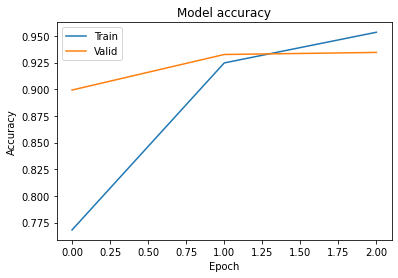

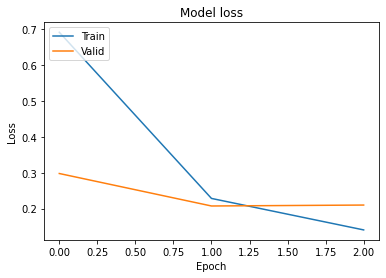



###------------- ACCURACY --------------###

model:  resnet50
f1:  0.9349643728441944
inference_time:  1.2781177520751954
accuracy:  0.9350416666666667
best_parameter:  {'dropout': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.005}


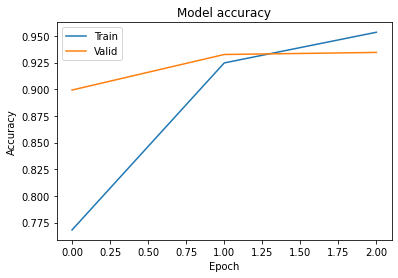

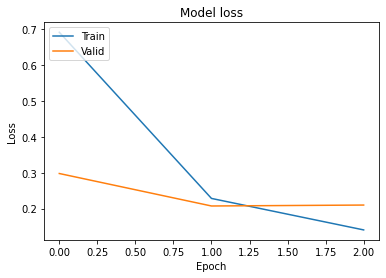



###------------- INFERENCE TIME --------------###

model:  vgg16
f1:  0.6060365267775805
inference_time:  0.15390589237213134
accuracy:  0.6131666666666666
best_parameter:  {'dropout': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0005}


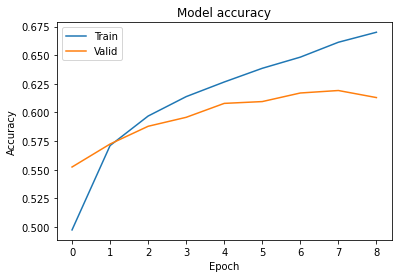

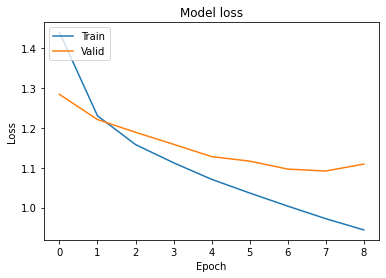




###------------- 1위 --------------###



###------------- F1 --------------###

model:  resnet50
f1:  0.9202027427892734
inference_time:  1.353424310684204
accuracy:  0.9201666666666667
best_parameter:  {'dropout': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.01}


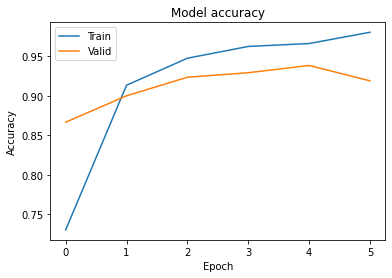

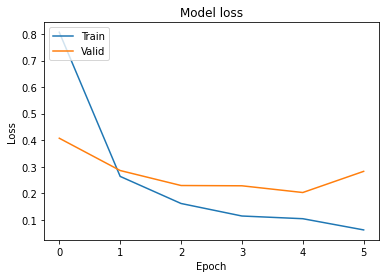



###------------- ACCURACY --------------###

model:  resnet50
f1:  0.9202027427892734
inference_time:  1.353424310684204
accuracy:  0.9201666666666667
best_parameter:  {'dropout': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.01}


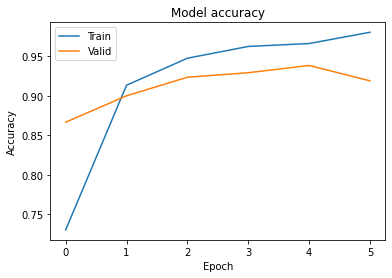

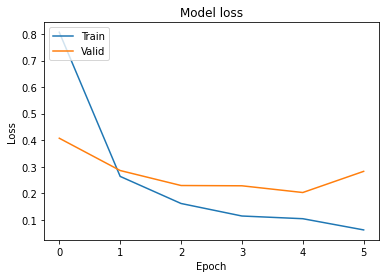



###------------- INFERENCE TIME --------------###

model:  vgg16
f1:  0.6083185179743867
inference_time:  0.1585611581802368
accuracy:  0.6101666666666666
best_parameter:  {'dropout': 0.3, 'optimizer': 'adam', 'learning_rate': 0.001}


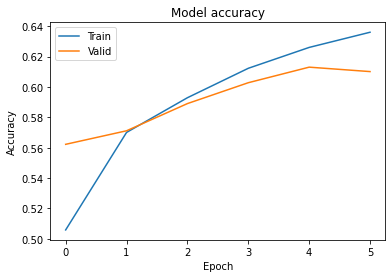

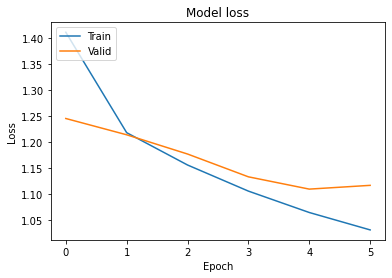




###------------- 2위 --------------###



###------------- F1 --------------###

model:  resnet50
f1:  0.917627280986679
inference_time:  1.3384653091430665
accuracy:  0.9182916666666666
best_parameter:  {'dropout': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.005}


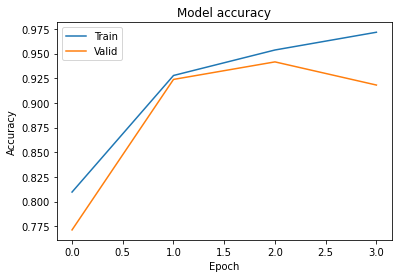

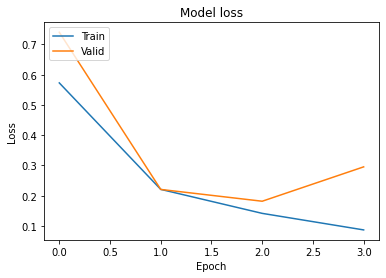



###------------- ACCURACY --------------###

model:  resnet50
f1:  0.917627280986679
inference_time:  1.3384653091430665
accuracy:  0.9182916666666666
best_parameter:  {'dropout': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.005}


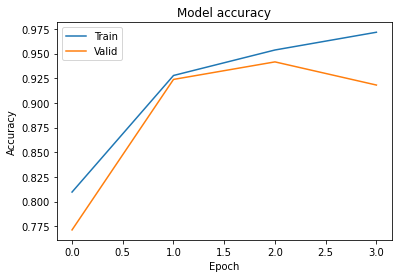

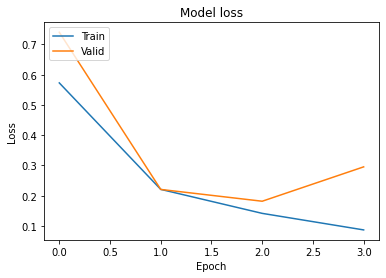



###------------- INFERENCE TIME --------------###

model:  vgg16
f1:  0.612316747201354
inference_time:  0.1595071315765381
accuracy:  0.614
best_parameter:  {'dropout': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0005}


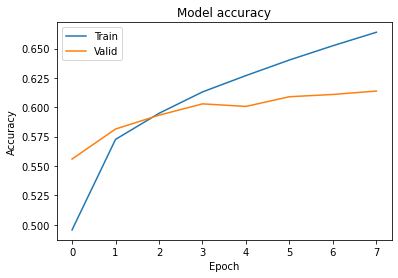

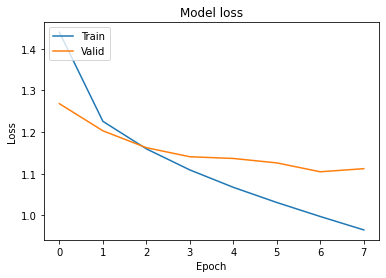

In [ ]:
from keras.datasets import cifar10

if __name__ == '__main__':
  (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
  X = np.concatenate((X_train,X_test))
  y = np.concatenate((Y_train,Y_test))

  cSystem = ComparisonSystem(X, y, num_class=10, epochs=16, rows=32, cols=32)

  cSystem.setSystem()
  cSystem.runSystem()
  
  cSystem.sortResult()

  #for i in range(0, 3):
  #all = cSystem.getResult()

  #print('\n\n###------------- ALL --------------###\n')
  #print(all)

  for i in range(0, 3):
    print()
    print(f'\n\n###------------- {i}위 --------------###\n')
    f1Result = cSystem.getResult('f1', i)
    accResult = cSystem.getResult('accuracy', i)
    itResult = cSystem.getResult('inference time', i)

    print('\n\n###------------- F1 --------------###\n')
    show_result(f1Result)
    graph = show_graph(f1Result)
    graph.show_accuracy()
    graph.show_loss()

    print('\n\n###------------- ACCURACY --------------###\n')
    show_result(accResult)
    graph = show_graph(accResult)
    graph.show_accuracy()
    graph.show_loss()

    print('\n\n###------------- INFERENCE TIME --------------###\n')
    show_result(itResult)
    graph = show_graph(itResult)
    graph.show_accuracy()
    graph.show_loss()

**참고 자료**
- https://koos808.tistory.com/42
